<a href="https://colab.research.google.com/github/cildiroyku/TransferLearningforAnimalSounds/blob/main/DLProjectSetupandTemplateforExperimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning Notebook

Instructions:

* This notebook has dependencies from a GitHub repo for the project that includes a config file, the path to YAMNet, embedding transofrmations for PyTorch. **Run Part 1 completely before starting to work on this notebook.**

* Part 2 is for demonstration purposes only on one sample audio clip. It was used to investigate the inner workings of YAMNet and understand how the embeddings need to be extracted and structured, to be able to process them. **Part 2 is optional to run.**

* Part 3 sets up a pipeline to extract embeddings. **Part 3 it should be run before proceeding.**

*

## Part1: Setting up to clone the repo from GitHub, get dependencies, model weights and connect to GPU

No need to modify this section. If GPU is not available, model will run on CPU.


In [ ]:
!git clone https://github.com/cildiroyku/TransferLearningforAnimalSounds.git
%cd TransferLearningforAnimalSounds
!ls -lh yamnet.pth

Cloning into 'TransferLearningforAnimalSounds'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 32 (delta 6), reused 12 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (32/32), 13.34 MiB | 13.23 MiB/s, done.
Resolving deltas: 100% (6/6), done.
/content/TransferLearningforAnimalSounds
-rw-r--r-- 1 root root 15M Nov 11 16:04 yamnet.pth


Imports and configuration load

In [ ]:
import yaml
cfg = yaml.safe_load(open("configs/base.yaml"))
print(cfg["data"]["sample_rate"])

16000


In [ ]:
!python test_config.py

Config loaded successfully!
Project name: transfer_learning_for_animal_sounds
Sample rate: 16000
Device preference: cuda

Verified folder: data/gtzan/
Verified folder: data/esc50/
Verified folder: outputs/embeddings/

GPU not detected — using CPU


In [ ]:
!git clone https://github.com/w-hc/torch_audioset.git


Cloning into 'torch_audioset'...
remote: Enumerating objects: 269, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 269 (delta 28), reused 26 (delta 26), pack-reused 237 (from 1)
Receiving objects: 100% (269/269), 662.51 KiB | 8.83 MiB/s, done.
Resolving deltas: 100% (141/141), done.


In [ ]:
!ls torch_audioset


LICENSE    README.md  test	  tools		  visualization.py
notebooks  setup.py   tf_2_torch  torch_audioset


In [ ]:
!find torch_audioset -maxdepth 2 -type f -name "*yamnet*.py"


torch_audioset/tf_2_torch/store_yamnet_pred_metadata_as_yml.py
torch_audioset/tf_2_torch/convert_yamnet.py


In [ ]:
!realpath torch_audioset/tf_2_torch/convert_yamnet.py

/content/TransferLearningforAnimalSounds/torch_audioset/tf_2_torch/convert_yamnet.py


In [ ]:
!find torch_audioset -type f -name "params.py"

torch_audioset/torch_audioset/params.py


In [ ]:
!find torch_audioset -type f -name "model.py"


torch_audioset/torch_audioset/yamnet/model.py
torch_audioset/torch_audioset/vggish/model.py


In [ ]:
import sys
sys.path.append("/content/TransferLearningforAnimalSounds/torch_audioset")

from torch_audioset.yamnet.model import yamnet as YamNet

In [ ]:
%cd /content/TransferLearningforAnimalSounds


/content/TransferLearningforAnimalSounds


In [ ]:
!ls configs


base.yaml


In [ ]:
import torch, yaml

device = "cuda" if torch.cuda.is_available() else "cpu"

with open("configs/base.yaml") as f:
    cfg = yaml.safe_load(f)

model = YamNet().to(device)
checkpoint = torch.load("yamnet.pth", map_location=device)
model.load_state_dict(checkpoint)
model.eval()

print("YAMNet model ready on", device)


Downloading: "https://github.com/w-hc/torch_audioset/releases/download/v0.1/yamnet.pth" to /root/.cache/torch/hub/checkpoints/yamnet.pth


100%|██████████| 14.4M/14.4M [00:00<00:00, 126MB/s]

YAMNet model ready on cpu


## Part 2:Testing YAMNet on a sample, real audio clip from the ESC-50 dataset

**What this section does**

* End-to-end flow from raw audio → embedding
* Fixing TensorFlow--> Pytorch compatibility for embedding sizes
* Creating a custom function to extract yamnet embeddings up to layer14
* Embedding matching of the correct feature dimension

### Downloading a test sound to check for sample rate and waveform

In [ ]:
import torch
import torchaudio
import torchaudio.transforms as T
import numpy as np

# Example environmental sound (dog bark)
url = "https://github.com/karoldvl/ESC-50/raw/master/audio/1-100032-A-0.wav"
waveform, sr = torchaudio.load(url)

print("Original sample rate:", sr, "| waveform shape:", waveform.shape)


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Original sample rate: 44100 | waveform shape: torch.Size([1, 220500])


### Pre-processing audio file imported aboce

In [ ]:
target_sr = cfg["data"]["sample_rate"]

# Resample if needed
if sr != target_sr:
    waveform = torchaudio.functional.resample(waveform, sr, target_sr)

# Convert to mono and normalize
waveform = waveform.mean(dim=0, keepdim=True)
waveform = waveform / waveform.abs().max()

print("Processed waveform shape:", waveform.shape)  # [1, N]

Processed waveform shape: torch.Size([1, 80000])


In [ ]:
# Parameters consistent with YAMNet's frontend
mel_transform = T.MelSpectrogram(
    sample_rate=target_sr,
    n_fft=1024,
    hop_length=160,
    n_mels=64,
    f_min=125,
    f_max=7500,
)
db_transform = T.AmplitudeToDB(stype="power")

# Convert
mel_spec = mel_transform(waveform)
mel_spec_db = db_transform(mel_spec)

print("Mel-spectrogram shape:", mel_spec_db.shape)  # [1, 64, T]

Mel-spectrogram shape: torch.Size([1, 64, 501])


In [ ]:
# YAMNet expects [frames, mel_bins], not batched [1, 64, T]
mel_spec_db = mel_spec_db.transpose(1, 2)  # → [1, T, 64]
mel_spec_db = mel_spec_db.squeeze(0)       # → [T, 64]

print("Final mel input shape for YAMNet:", mel_spec_db.shape)

Final mel input shape for YAMNet: torch.Size([501, 64])


In [ ]:
mel_spec_db = mel_spec_db.unsqueeze(0).unsqueeze(0)
print("Final mel input shape for YAMNet:", mel_spec_db.shape)

Final mel input shape for YAMNet: torch.Size([1, 1, 501, 64])


In [ ]:
print(model)

YAMNet(
  (layer1): Conv(
    (fused): CONV_BN_RELU(
      (conv): Conv2d_tf(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=SAME, bias=False)
      (bn): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  )
  (layer2): SeparableConv(
    (depthwise_conv): CONV_BN_RELU(
      (conv): Conv2d_tf(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=SAME, groups=32, bias=False)
      (bn): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pointwise_conv): CONV_BN_RELU(
      (conv): Conv2d_tf(32, 64, kernel_size=(1, 1), stride=(1, 1), padding=SAME, bias=False)
      (bn): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  )
  (layer3): SeparableConv(
    (depthwise_conv): CONV_BN_RELU(
      (conv): Conv2d_tf(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=SAME, groups=64, bias=False)
      (bn): BatchNorm2d(

In [ ]:
def extract_yamnet_embedding(model, mel_features):
    """
    Runs YAMNet backbone up to layer14 → returns 1024-D embedding
    Input shape: [1, 1, frames, 64]
    """
    with torch.no_grad():
        x = model.layer1(mel_features)
        x = model.layer2(x)
        x = model.layer3(x)
        x = model.layer4(x)
        x = model.layer5(x)
        x = model.layer6(x)
        x = model.layer7(x)
        x = model.layer8(x)
        x = model.layer9(x)
        x = model.layer10(x)
        x = model.layer11(x)
        x = model.layer12(x)
        x = model.layer13(x)
        x = model.layer14(x)

        # Global average pooling across spatial dims
        x = torch.mean(x, dim=[2, 3])  # [batch, 1024]
        return x.squeeze(0)


### Passing through YAMNet to extract embeddings

In [ ]:
clip_embedding = extract_yamnet_embedding(model, mel_spec_db)
print("Embedding shape:", clip_embedding.shape)


Embedding shape: torch.Size([1024])


## Part 3: Making a reusable pipeline to extract YAMNet embeddings

In [ ]:
import torchaudio
import torchaudio.transforms as T
import torch

def yamnet_extract_from_file(model, file_path, cfg):
    """
    Full pipeline: loads audio, converts to log-mel, extracts 1024-D embedding.
    Returns a PyTorch tensor [1024].
    """
    target_sr = cfg["data"]["sample_rate"]

    # --- Load and resample ---
    waveform, sr = torchaudio.load(file_path)
    if sr != target_sr:
        waveform = torchaudio.functional.resample(waveform, sr, target_sr)
    waveform = waveform.mean(dim=0, keepdim=True)
    waveform = waveform / waveform.abs().max()

    # --- Mel spectrogram ---
    mel_transform = T.MelSpectrogram(
        sample_rate=target_sr,
        n_fft=1024,
        hop_length=160,
        n_mels=64,
        f_min=125,
        f_max=7500,
    )
    db_transform = T.AmplitudeToDB(stype="power")
    mel_spec = mel_transform(waveform)
    mel_spec_db = db_transform(mel_spec)

    # --- Prepare for YAMNet ---
    mel_spec_db = mel_spec_db.transpose(1, 2).unsqueeze(0)


    # --- Forward through YAMNet backbone ---
    with torch.no_grad():
        x = model.layer1(mel_spec_db)
        x = model.layer2(x)
        x = model.layer3(x)
        x = model.layer4(x)
        x = model.layer5(x)
        x = model.layer6(x)
        x = model.layer7(x)
        x = model.layer8(x)
        x = model.layer9(x)
        x = model.layer10(x)
        x = model.layer11(x)
        x = model.layer12(x)
        x = model.layer13(x)
        x = model.layer14(x)
        x = torch.mean(x, dim=[2, 3])  # [batch, 1024]

    return x.squeeze(0)

In [ ]:
url = "https://github.com/karoldvl/ESC-50/raw/master/audio/1-100032-A-0.wav"
waveform, sr = torchaudio.load(url)

In [ ]:
#Sample usage:

path = "/content/TransferLearningforAnimalSounds/data/esc50/1-100032-A-0.wav"
torch.save(waveform, "sample_waveform.pt")
emb = yamnet_extract_from_file(model, url, cfg)

print(emb.shape)  # torch.Size([1024])

torch.Size([1024])


## Part 4: Loading the Data for Extraction

Make sure you point the extraction function below to where you have the audio files from ESC-50 saved on your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -r "/content/drive/MyDrive/DeepLearning/ESC-50-master/audio" /content/audio

## Part 5: Creating a Pipeline That Processes All Audio Clips in Batch

Building a function that:

* walks through a dataset folder (e.g. data/esc50),

* extracts one 1024-D embedding per audio file,

* saves each embedding to a structured directory (outputs/embeddings/{dataset_name}/),

* writes a summary .csv or .npy file for downstream training.

In [100]:
import os
import numpy as np
from tqdm import tqdm
import glob

def extract_embeddings_from_folder(model, folder_path, cfg, save_dir):
    import os, glob
    import numpy as np
    from tqdm import tqdm

    os.makedirs(save_dir, exist_ok=True)
    embeddings, labels = [], []

    # Glob reference folder_path
    wav_files = glob.glob(os.path.join(folder_path, "*.wav"))
    print(f"🔍 Found {len(wav_files)} WAV files in: {folder_path}")

    if len(wav_files) == 0:
        print("No .wav files found — check your folder path!")
        return

    for file_path in tqdm(wav_files):
        try:
            emb = yamnet_extract_from_file(model, file_path, cfg)
            embeddings.append(emb.numpy())

            # ✅ Extract the class ID (last number before .wav)
            filename = os.path.basename(file_path)
            label = int(filename.split('-')[-1].split('.')[0])
            labels.append(label)

        except Exception as e:
            print(f"Skipping {file_path}: {e}")

    # Stack and save arrays
    embeddings = np.stack(embeddings)
    labels = np.array(labels)

    np.save(os.path.join(save_dir, "embeddings.npy"), embeddings)
    np.save(os.path.join(save_dir, "labels.npy"), labels)

    print(f"Saved embeddings: {embeddings.shape} | Labels: {len(labels)}")
    print(f"Label range: {labels.min()} → {labels.max()} (unique={len(np.unique(labels))})")


In [101]:
extract_embeddings_from_folder(
    model,
    "/content/drive/MyDrive/DeepLearning/ESC-50-master/audio",
    cfg,
    "outputs/embeddings/esc50"
)

🔍 Found 2000 WAV files in: /content/drive/MyDrive/DeepLearning/ESC-50-master/audio


  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues

Saved embeddings: (2000, 1024) | Labels: 2000
Label range: 0 → 49 (unique=50)


## GTZAN Segment Based Extraction

GTZAN audio files are 30 sec long, which are way larger than the less than 10s expected length for YAMNet. So we proceed with segment-based embedding extraction.

Handles genre subfolders automatically (blues, rock, etc.)

Segments each 30s clip into overlapping 3s windows

Converts to Mel spectrograms consistent with YAMNet frontend

Performs embedding extraction manually (like your ESC-50 extractor backbone)

Optionally aggregates per song (or saves every segment)

Saves embeddings.npy + labels.npy in your chosen output folder

In [54]:
#The extraction for GTZAN (it is different since the shapes are different)
import os
import torch
import torchaudio
import numpy as np
from tqdm import tqdm
import glob

def extract_embeddings_from_gtzan(model, folder_path, cfg, save_dir,
                                  segment_length=3.0, overlap=0.5, aggregate=True):
    """
    Extracts YAMNet embeddings from GTZAN dataset (30s music clips).
    Includes segmentation and Mel spectrogram transform for each segment.

    Args:
        model: Loaded YAMNet model.
        folder_path: Path to GTZAN root folder (contains genre subfolders).
        cfg: Configuration dictionary (for sample rate etc.).
        save_dir: Directory where embeddings and labels are saved.
        segment_length: Segment duration in seconds (default = 3.0).
        overlap: Overlap fraction between segments (default = 0.5).
        aggregate: Whether to average embeddings per song (True) or save all segments (False).

    Saves:
        embeddings.npy (shape: [n_songs, 1024]) or [n_segments, 1024]
        labels.npy (list of corresponding genre labels)
    """

    os.makedirs(save_dir, exist_ok=True)
    target_sr = cfg["data"]["sample_rate"]

    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=target_sr,
        n_fft=1024,
        hop_length=160,
        n_mels=64,
        f_min=125,
        f_max=7500,
    )
    db_transform = torchaudio.transforms.AmplitudeToDB(stype='power')

    embeddings, labels = [], []

    # loop through genre folders
    for genre_folder in sorted(os.listdir(folder_path)):
        genre_path = os.path.join(folder_path, genre_folder)
        if not os.path.isdir(genre_path):
            continue

        print(f"\n🎵 Processing genre: {genre_folder}")
        wav_files = glob.glob(os.path.join(genre_path, "*.wav"))

        for i, file_path in enumerate(tqdm(wav_files, desc=genre_folder)):
            try:
                waveform, sr = torchaudio.load(file_path)
                if sr != target_sr:
                    waveform = torchaudio.functional.resample(waveform, sr, target_sr)

                # Convert stereo → mono
                waveform = waveform.mean(dim=0, keepdim=True)

                # Segment audio
                samples_per_seg = int(target_sr * segment_length)
                hop_size = int(samples_per_seg * (1 - overlap))
                segments = []
                for start in range(0, waveform.shape[1] - samples_per_seg + 1, hop_size):
                    segment = waveform[:, start:start + samples_per_seg]
                    segments.append(segment)

                song_embeds = []
                for seg in segments:
                    # Convert to mel-spectrogram
                    mel_spec = mel_transform(seg)
                    mel_spec_db = db_transform(mel_spec)
                    mel_spec_db = mel_spec_db.transpose(1, 2).unsqueeze(0)  # [1, 1, frames, mel_bins]
  # [1, 1, frames, mel_bins]

                    with torch.no_grad():
                        x = model.layer1(mel_spec_db)
                        x = model.layer2(x)
                        x = model.layer3(x)
                        x = model.layer4(x)
                        x = model.layer5(x)
                        x = model.layer6(x)
                        x = model.layer7(x)
                        x = model.layer8(x)
                        x = model.layer9(x)
                        x = model.layer10(x)
                        x = model.layer11(x)
                        x = model.layer12(x)
                        x = model.layer13(x)
                        x = model.layer14(x)
                        x = torch.mean(x, dim=[2, 3])  # global average pooling
                        song_embeds.append(x.squeeze(0).cpu().numpy())

                # Aggregate segments per song
                if len(song_embeds) > 0:
                    if aggregate:
                        emb = np.mean(song_embeds, axis=0)
                        embeddings.append(emb)
                        labels.append(genre_folder)
                    else:
                        for emb in song_embeds:
                            embeddings.append(emb)
                            labels.append(genre_folder)

            except Exception as e:
                print(f"Skipping {file_path}: {e}")

    if len(embeddings) == 0:
        print("⚠️ No embeddings extracted — check your folder or file paths!")
        return

    embeddings = np.stack(embeddings)
    np.save(os.path.join(save_dir, "embeddings.npy"), embeddings)
    np.save(os.path.join(save_dir, "labels.npy"), np.array(labels))
    print(f"\n✅ Saved embeddings: {embeddings.shape} | Labels: {len(labels)}")


In [55]:
extract_embeddings_from_gtzan(
    model,
    "/content/drive/MyDrive/DeepLearning/GTZAN/genres_original",
    cfg,
    "outputs/embeddings/gtzan",
    segment_length=3.0,  # seconds
    overlap=0.5,         # 50% overlap
    aggregate=True        # average across segments per song
)


🎵 Processing genre: blues


blues: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]



🎵 Processing genre: classical


classical: 100%|██████████| 100/100 [00:49<00:00,  2.02it/s]



🎵 Processing genre: country


country: 100%|██████████| 100/100 [00:49<00:00,  2.04it/s]



🎵 Processing genre: disco


disco: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s]



🎵 Processing genre: hiphop


hiphop: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]



🎵 Processing genre: jazz


jazz:  43%|████▎     | 43/100 [00:21<00:24,  2.29it/s]

Skipping /content/drive/MyDrive/DeepLearning/GTZAN/genres_original/jazz/jazz.00054.wav: Failed to open the input "/content/drive/MyDrive/DeepLearning/GTZAN/genres_original/jazz/jazz.00054.wav" (Invalid data found when processing input).


jazz: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]



🎵 Processing genre: metal


metal: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s]



🎵 Processing genre: pop


pop: 100%|██████████| 100/100 [00:49<00:00,  2.02it/s]



🎵 Processing genre: reggae


reggae: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]



🎵 Processing genre: rock


rock: 100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


✅ Saved embeddings: (999, 1024) | Labels: 999


## Part 6: Loading embeddings as predictors and labels



In [120]:
import numpy as np

X_esc = np.load("outputs/embeddings/esc50/embeddings.npy")
y_esc = np.load("outputs/embeddings/esc50/labels.npy")

X_gtzan = np.load("outputs/embeddings/gtzan/embeddings.npy")
y_gtzan = np.load("outputs/embeddings/gtzan/labels.npy")

print(X_esc.shape, y_esc.shape)
print(X_gtzan.shape, y_gtzan.shape)

(2000, 1024) (2000,)
(999, 1024) (999,)


### Zero-Shot
Train: GTZAN
Test: ESC-50

In [121]:
X_train, y_train = X_gtzan, y_gtzan
X_test,  y_test  = X_esc, y_esc

## Part 7: Training a Classifier - Random Forest

The main purpose of this section is to run zero-shot and few-shot experiments using classifiers such as Random Forest, SVM, KNN, Naive Bayes.

### Normalizing the features

In [115]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [116]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

### Training and testing the model

In [117]:
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

In [118]:
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

In [119]:
y_pred = rf.predict(X_test_scaled)
print("Zero-shot accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Zero-shot accuracy: 0.0


ValueError: Mix of label input types (string and number)

### Inspecting Class Confusions

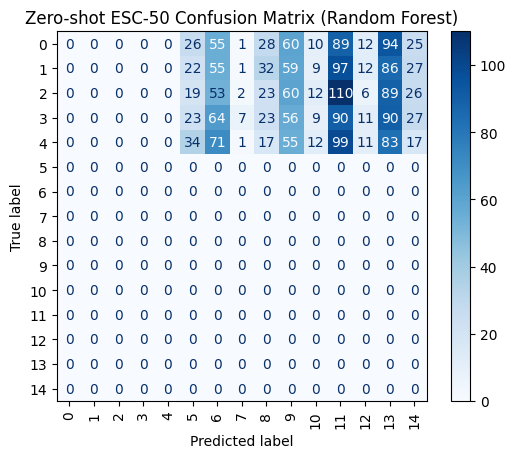

In [108]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(
    xticks_rotation='vertical', cmap='Blues'
)
plt.title("Zero-shot ESC-50 Confusion Matrix (Random Forest)")
plt.show()

### Few Shot training

Zero shot was basically useless

In [129]:
from sklearn.preprocessing import LabelEncoder

# Convert GTZAN string labels to integers
le_gtzan = LabelEncoder()
y_gtzan_enc = le_gtzan.fit_transform(y_gtzan)

# ESC-50 labels are already numeric, just ensure they’re np.int64
y_esc_enc = y_esc.astype(int)

# Optional: verify consistency
print("GTZAN label range:", y_gtzan_enc.min(), "→", y_gtzan_enc.max(), "| unique:", len(np.unique(y_gtzan_enc)))
print("ESC-50 label range:", y_esc_enc.min(), "→", y_esc_enc.max(), "| unique:", len(np.unique(y_esc_enc)))

GTZAN label range: 0 → 9 | unique: 10
ESC-50 label range: 0 → 49 | unique: 50


In [130]:
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from collections import defaultdict

# -----------------------
#  Few-shot helper
# -----------------------
def sample_few_shot(X, y, k, seed=42):
    """
    Sample k examples per class from (X, y)
    Returns few-shot (X_fs, y_fs) and the remaining (X_rest, y_rest)
    """
    rng = np.random.default_rng(seed)
    classes = np.unique(y)
    idx_fs, idx_rest = [], []

    for cls in classes:
        cls_idx = np.where(y == cls)[0]
        rng.shuffle(cls_idx)
        k_ = min(k, len(cls_idx))
        idx_fs.extend(cls_idx[:k_])
        idx_rest.extend(cls_idx[k_:])

    X_fs, y_fs = X[idx_fs], y[idx_fs]
    X_rest, y_rest = X[idx_rest], y[idx_rest]
    return X_fs, y_fs, X_rest, y_rest


# -----------------------
#  Few-shot training loop
# -----------------------
def few_shot_experiment(X_gtzan, y_gtzan, X_esc, y_esc, k_values=[1, 5, 10, 20]):
    """
    Runs few-shot experiments by sampling k labeled ESC-50 examples per class,
    training a Random Forest on GTZAN + few-shot ESC-50, and testing on the rest.
    """
    results = defaultdict(dict)

    # ✅ Encode GTZAN labels (string → integer)
    if isinstance(y_gtzan[0], str):
        le_gtzan = LabelEncoder()
        y_gtzan = le_gtzan.fit_transform(y_gtzan)

    # ✅ Ensure ESC-50 labels are integers
    y_esc = y_esc.astype(int)

    # ✅ Align label ranges (optional safety)
    y_gtzan = np.array(y_gtzan, dtype=int)
    y_esc = np.array(y_esc, dtype=int)

    print(f"GTZAN label range: {y_gtzan.min()} → {y_gtzan.max()} | unique: {len(np.unique(y_gtzan))}")
    print(f"ESC-50 label range: {y_esc.min()} → {y_esc.max()} | unique: {len(np.unique(y_esc))}")

    for k in k_values:
        print(f"\n🎯 Running few-shot experiment with k={k} samples per class")

        # --- Sample few-shot ESC-50 subset ---
        X_fs, y_fs, X_rest, y_rest = sample_few_shot(X_esc, y_esc, k)

        # --- Combine GTZAN + few ESC-50 samples ---
        X_train = np.concatenate([X_gtzan, X_fs])
        y_train = np.concatenate([y_gtzan, y_fs])
        X_test, y_test = X_rest, y_rest

        # --- Normalize ---
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # --- Train Random Forest ---
        rf = RandomForestClassifier(
            n_estimators=500,
            max_depth=None,
            min_samples_split=2,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_train_scaled, y_train)

        # --- Evaluate ---
        y_pred = rf.predict(X_test_scaled)
        acc = accuracy_score(y_test, y_pred)
        print(f"✅ Accuracy (k={k}): {acc:.4f}")
        print(classification_report(y_test, y_pred, digits=3))

        results[k]["accuracy"] = acc
        results[k]["report"] = classification_report(y_test, y_pred, digits=3, output_dict=True)

    return results

In [131]:
import numpy as np

X_esc_enc = np.load("outputs/embeddings/esc50/embeddings.npy")
y_esc_enc = np.load("outputs/embeddings/esc50/labels.npy")
X_gtzan_enc = np.load("outputs/embeddings/gtzan/embeddings.npy")
y_gtzan_enc = np.load("outputs/embeddings/gtzan/labels.npy")

print(X_esc_enc.shape, np.unique(y_esc_enc).shape)
print(X_gtzan_enc.shape, np.unique(y_gtzan_enc).shape)

(2000, 1024) (50,)
(999, 1024) (10,)


In [ ]:
results = few_shot_experiment(
    X_gtzan_enc, y_gtzan_enc,
    X_esc_enc, y_esc_enc,
    k_values=[1, 5, 10, 20]
)

GTZAN label range: 0 → 9 | unique: 10
ESC-50 label range: 0 → 49 | unique: 50

🎯 Running few-shot experiment with k=1 samples per class


In [ ]:
import matplotlib.pyplot as plt

k_vals = list(results.keys())
acc_vals = [results[k]["accuracy"] for k in k_vals]

plt.figure(figsize=(6,4))
plt.plot(k_vals, acc_vals, marker="o", color="royalblue")
plt.title("Few-shot Learning Performance (GTZAN → ESC-50)")
plt.xlabel("Number of labeled ESC-50 samples per class (k)")
plt.ylabel("Accuracy")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

## Part 8: Visualizing the embedding space

The purpose here is to see the clusters of sound categories that came out of our classifier.

## Part 9: Transfer Learning / Fine-Tuning

## Part 10: